In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter  , PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   

2.4942528735632186

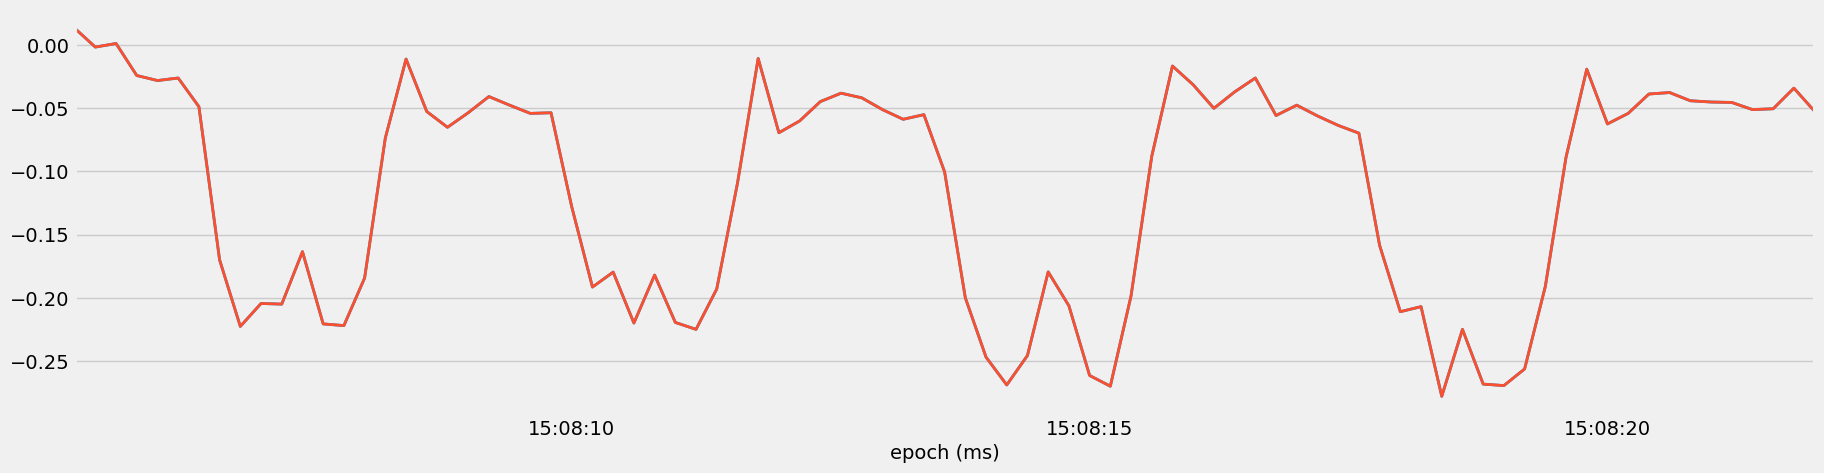

In [48]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------

df = pd.read_pickle(r'../../data/interim/02_outliers_removed_chauvenets.pkl')

sensor_col = list(df.columns[:6])


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2

# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------

df.info()
# Interpolation is a technique used in mathematics and statistics to estimate values between two known values. In the context of Pandas DataFrames, interpolation can be applied along rows or columns to estimate missing values based on neighboring data points.
# df['acc_x'].interpolate().isna().sum()

df[df['set']== 30]['acc_x'].plot()

for col in sensor_col:
    df[col] = df[col].interpolate()
    
df.info()

df[df['set']== 30]['acc_x'].plot()

# --------------------------------------------------------------
# Calculating set duration
# --------------------------------------------------------------

#We know that: the heavy set contains 5 repetitions, and medium set contains 10 repetitions for each exercise

#Now we need to know the duration for each set

for set in  df['set'].unique():
    
    strart = df[df['set'] == set].index[0]
    end = df[df['set'] == set].index[-1]
    
    duration = end - strart
    
    df.loc[(df['set'] == set) , 'duration'] = duration.seconds
    

duration_df =  df.groupby('category')['duration'].mean()    

duration_df[0] / 5 # so each repetition take 2.9 sec in heavy set
duration_df[1] / 10 # so each repetition take 2.4 sec in medium set

In [51]:
df_lowpass = df.copy()

ohp


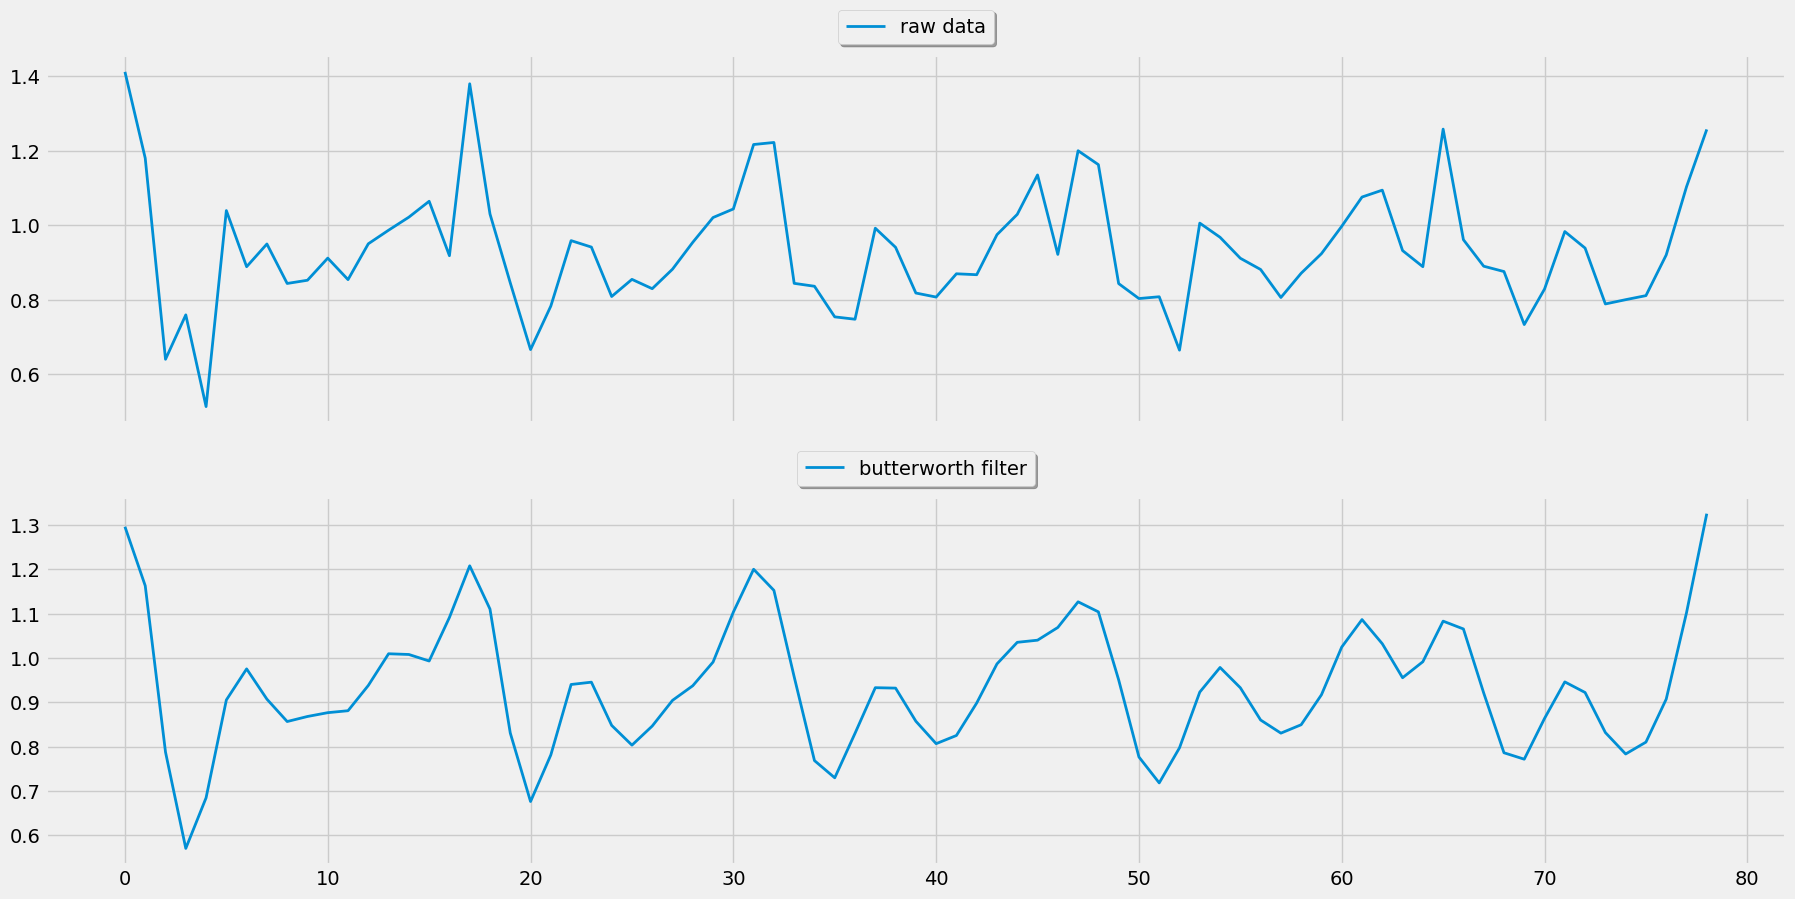

In [50]:


LowPass = LowPassFilter()

sampling_frq = 1000 / 200 # # because we are taking the record every 200 ms, so that line calculates number of repetition in 1 sec

cutoff_frq = 1.3 # the low cutoff frequency, meaning more smoothing in signal

LowPass.low_pass_filter(df_lowpass , 'acc_y' , sampling_frq , cutoff_frq)

subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

In [52]:
for col in sensor_col:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, sampling_frq, cutoff_frq, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

In [53]:
df.mean()

C:\Users\xobed\AppData\Local\Temp\ipykernel_7628\3698961737.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean()


acc_x        0.038937
acc_y        0.069837
acc_z        0.104170
gyr_x        0.793243
gyr_y       -2.011683
gyr_z        0.811903
set         46.233100
duration    22.415584
dtype: float64

In [54]:
df_lowpass.mean()

C:\Users\xobed\AppData\Local\Temp\ipykernel_7628\77430902.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_lowpass.mean()


acc_x        0.038937
acc_y        0.069838
acc_z        0.104170
gyr_x        0.793472
gyr_y       -2.011739
gyr_z        0.811772
set         46.233100
duration    22.415584
dtype: float64

<Axes: xlabel='epoch (ms)'>

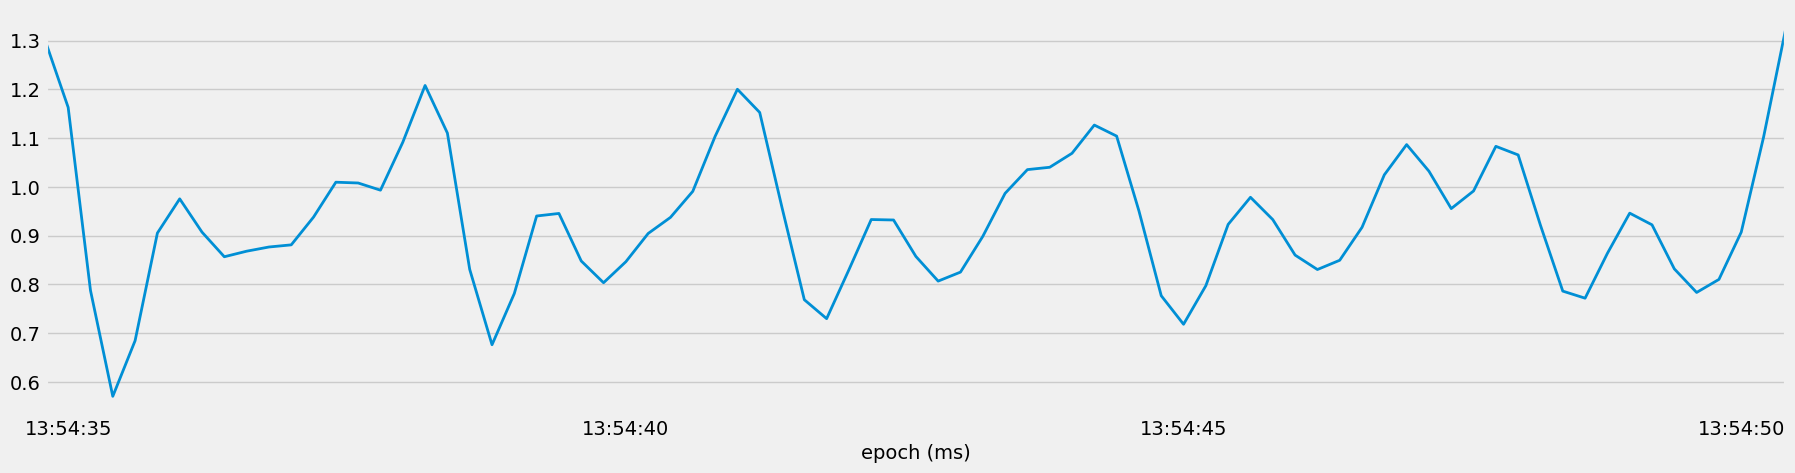

In [55]:
df_lowpass[df_lowpass["set"] == 45]['acc_y'].plot()

In [25]:
# --------------------------------------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------

In [56]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

In [57]:
pc_values =  PCA.determine_pc_explained_variance(df_pca , sensor_col)

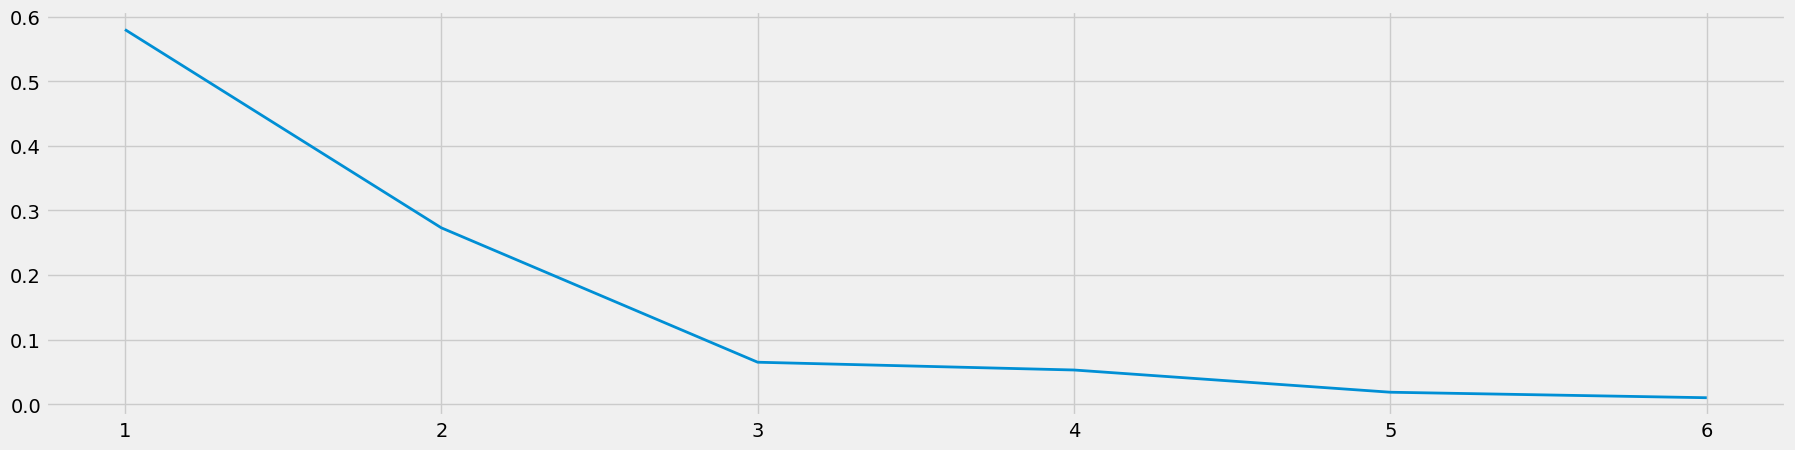

In [58]:
plt.plot(range(1, 7) , pc_values)

In [59]:
df_pca = PCA.apply_pca(df_pca , sensor_col , 3 )

In [60]:
df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,30,16.0,-0.315889,-0.075461,0.072243
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,30,16.0,-0.314873,-0.073888,0.069825
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,30,16.0,-0.314236,-0.080343,0.066219
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,30,16.0,-0.314356,-0.090852,0.061839
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,30,16.0,-0.313630,-0.097479,0.062974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,19.0,0.349351,-0.148450,-0.053031
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,90,19.0,0.371610,-0.151455,-0.058498
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,90,19.0,0.368098,-0.153153,-0.058772


<Axes: xlabel='epoch (ms)'>

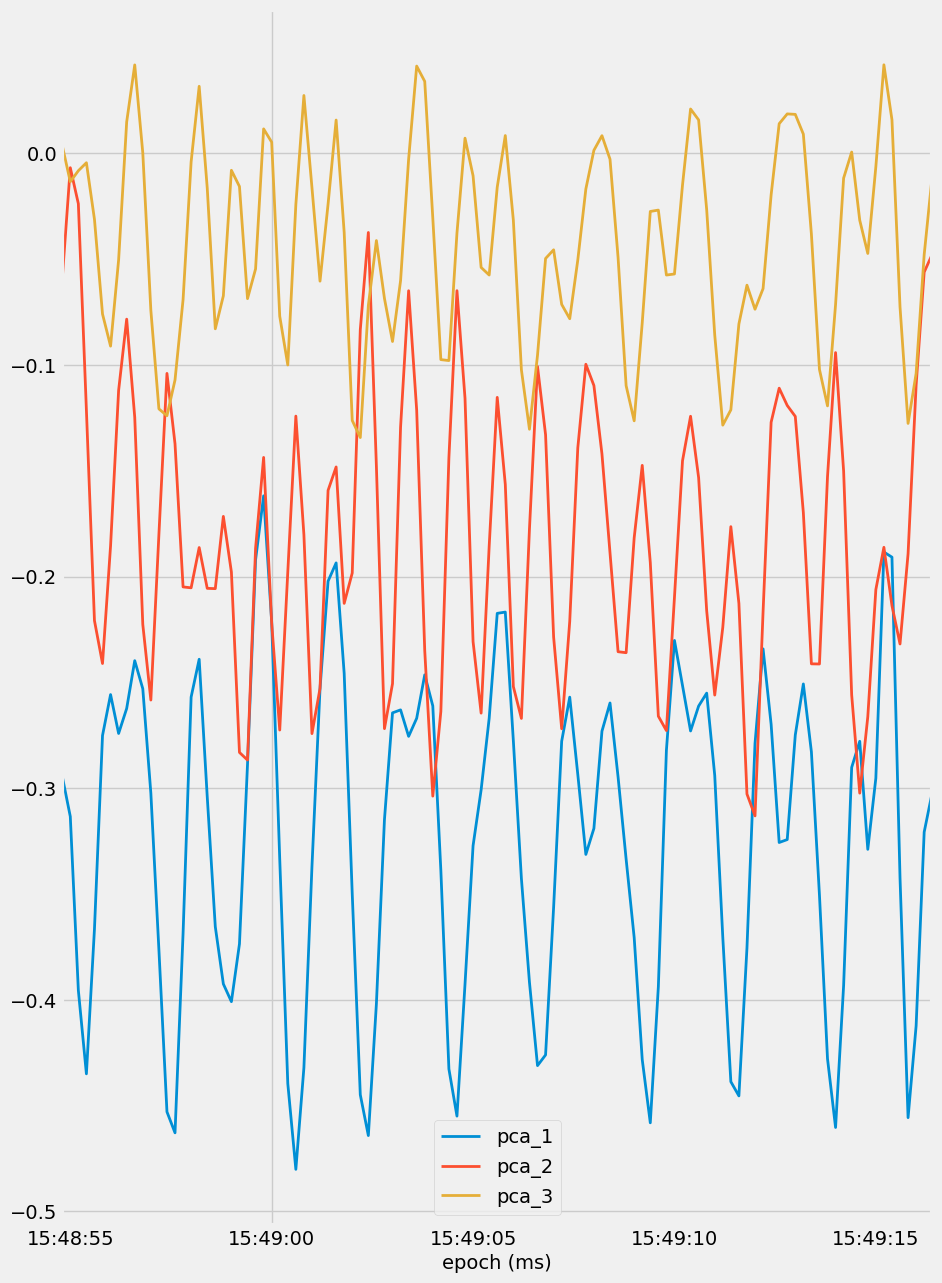

In [63]:
subset = df_pca[df_pca["set"] == 35] 

subset[['pca_1' , 'pca_2' , 'pca_3']].plot(figsize = (10,15))

In [64]:
df_squares = df_pca.copy()

acc_r = df_squares['acc_x'] **2 + df_squares['acc_y'] **2 +df_squares['acc_z'] **2 
gyr_r = df_squares['gyr_x'] **2 + df_squares['gyr_y'] **2 +df_squares['gyr_z'] **2 


df_squares['acc_r'] = np.sqrt(acc_r)
df_squares['gyr_r'] = np.sqrt(gyr_r)



The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [65]:
df_squares

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,30,16.0,-0.315889,-0.075461,0.072243,0.979672,3.222503
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,30,16.0,-0.314873,-0.073888,0.069825,0.975474,0.600176
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,30,16.0,-0.314236,-0.080343,0.066219,0.969585,4.948974
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,30,16.0,-0.314356,-0.090852,0.061839,0.966278,5.903203
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,30,16.0,-0.313630,-0.097479,0.062974,0.964693,2.293593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,19.0,0.349351,-0.148450,-0.053031,0.991076,4.508719
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,90,19.0,0.371610,-0.151455,-0.058498,1.056234,4.289212
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,90,19.0,0.368098,-0.153153,-0.058772,1.047919,2.329568


array([<Axes: xlabel='epoch (ms)'>, <Axes: xlabel='epoch (ms)'>],
      dtype=object)

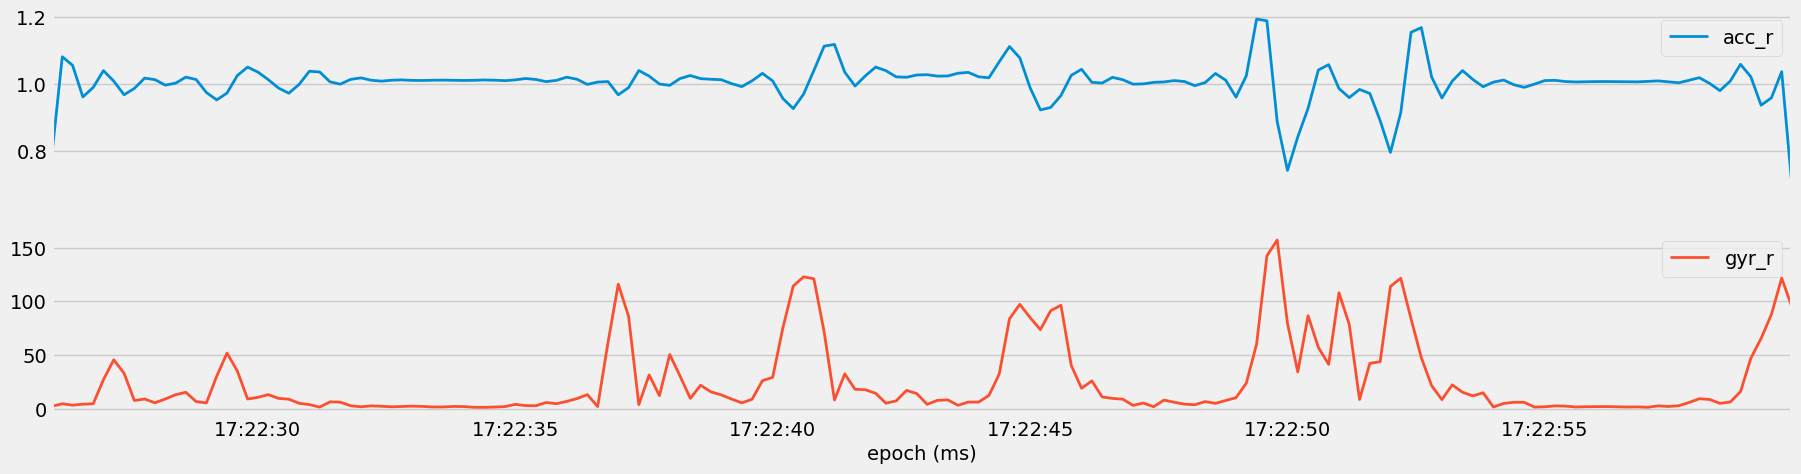

In [66]:
subset = df_squares[df_pca["set"] == 18] 

subset[['acc_r' , 'gyr_r' ]].plot(subplots = True)

In [46]:
df_squares

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013512,0.976987,-0.071010,-1.884255,2.436355,0.941786,B,bench,heavy,30,16.0,-0.318355,-0.076387,0.067901,0.979658,3.220746
2019-01-11 15:08:05.400,0.006580,0.969518,-0.067388,3.539042,0.623316,-2.118473,B,bench,heavy,30,16.0,-0.316125,-0.075835,0.071449,0.971880,4.171483
2019-01-11 15:08:05.600,-0.009918,0.961722,-0.074060,4.147837,-2.060668,-0.861710,B,bench,heavy,30,16.0,-0.314985,-0.082905,0.065776,0.964620,4.710993
2019-01-11 15:08:05.800,-0.022778,0.966266,-0.083894,0.643780,-3.742404,1.769295,B,bench,heavy,30,16.0,-0.317977,-0.090703,0.057287,0.970168,4.189326
2019-01-11 15:08:06.000,-0.019506,0.970668,-0.092616,1.018676,-1.290089,-2.373743,B,bench,heavy,30,16.0,-0.319401,-0.095058,0.062125,0.975272,2.887332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045839,-0.968329,-0.061228,3.682912,-4.681857,0.163887,E,row,medium,90,19.0,0.345901,-0.146409,-0.049010,0.971345,5.959068
2019-01-20 17:33:27.200,-0.043442,-1.006030,-0.054357,-2.656108,-2.173017,1.159846,E,row,medium,90,19.0,0.359056,-0.143075,-0.059879,1.008434,3.622452
2019-01-20 17:33:27.400,-0.046618,-1.053563,-0.066074,-0.912836,-1.697902,1.184195,E,row,medium,90,19.0,0.374901,-0.152092,-0.058774,1.056662,2.262401
